In [1]:
import numpy as np
import pandas as pd
import scipy.optimize
import urllib
import random
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
from sklearn.metrics import accuracy_score

In [2]:
def parseData(fname):
    for l in urllib.urlopen(fname):
        yield eval(l)    # yield : Iterators vs Generators, eval : Read the line as though it is a native object
        
print "Reading data..."
data = list(parseData('beer_50000.json'))
print "done"

Reading data...
done


In [3]:
data[0]

{'beer/ABV': 5.0,
 'beer/beerId': '47986',
 'beer/brewerId': '10325',
 'beer/name': 'Sausa Weizen',
 'beer/style': 'Hefeweizen',
 'review/appearance': 2.5,
 'review/aroma': 2.0,
 'review/overall': 1.5,
 'review/palate': 1.5,
 'review/taste': 1.5,
 'review/text': 'A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.',
 'review/timeStruct': {'hour': 20,
  'isdst': 0,
  'mday': 16,
  'min': 57,
  'mon': 2,
  'sec': 3,
  'wday': 0,
  'yday': 47,
  'year': 2009},
 'review/timeUnix': 1234817823,
 'user/profileName': 'stcules'}

## 1. Simple predictor using *year* as the feature

In [4]:
def feature(datum):
    feat = [1, datum['review/timeStruct']['year']]
    return feat

Max year =  2012 ; Min Year =  1999


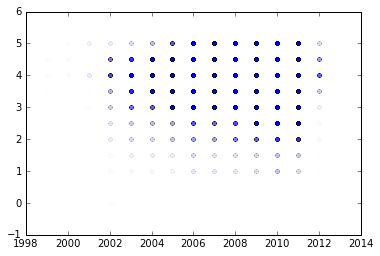

In [5]:
X = [feature(d) for d in data]
yr = [d['review/timeStruct']['year'] for d in data]
# print X[:10]
y = [d['review/overall'] for d in data]
# print y[:10]
maxyr = max(yr)
minyr = min(yr)
print "Max year = ", maxyr, "; Min Year = ", minyr
plt.scatter(yr, y, alpha=0.005)

In [6]:
theta, residuals, rank, s = np.linalg.lstsq(X, y)

In [7]:
print theta
print (residuals / len(y)) # MSE

[ -3.91707489e+01   2.14379786e-02]
[ 0.49004382]


## 2. Better representation of *year* variable using One-Hot encoding

$$quality = \theta_0 + \sum_{i = 1}^{13} \theta_i \times I(1999+i-1, year)$$
where I is the indicator function

In [8]:
def feature2(datum):
    feat = [0]*(maxyr-minyr+1) # Taking 13 years for one-hot instead of 14 to remove redundant feature + bias
    feat[0] = 1
    year = datum['review/timeStruct']['year']
    if year != maxyr:
        feat[year-minyr+1] = 1    
    return feat 

In [9]:
X = [feature2(d) for d in data]
X[:10]

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]

In [10]:
theta, residuals, rank, s = np.linalg.lstsq(X, y)
print theta
print "MSE = ", (residuals / len(y))

[ 4.05154639  0.04845361  0.26663543  0.2247694  -0.29273378 -0.33610958
 -0.29110335 -0.19133134 -0.24438704 -0.20546893 -0.16067206 -0.1301398
 -0.15473656 -0.11142557]
MSE =  [ 0.4891519]


We see very little improvement in the MSE showing that year is not a good feature after all

## 3. Linear Regression on Wine Quality dataset

In [11]:
import pandas as pd

In [12]:
wineFeatures = pd.read_csv('winequality-white.csv', delimiter=';')
wineQuality = wineFeatures['quality']
del wineFeatures['quality']
X = wineFeatures.values
y = wineQuality.values
X = np.insert(X, 0, 1, axis=1)
print y.shape, X.shape

(4898L,) (4898L, 12L)


In [13]:
X_train = X[:len(X)/2, :]
y_train = y[:len(y)/2]
X_test = X[len(X)/2:, :]
y_test = y[len(y)/2:]
print X_train.shape, X_test.shape


(2449L, 12L) (2449L, 12L)


In [14]:
theta, residuals, rank, s = np.linalg.lstsq(X_train, y_train)
print theta
# print "Residuals = ", residuals
# print "MSE = ", residuals / len(y_train)

[  2.56420279e+02   1.35421303e-01  -1.72994866e+00   1.02651152e-01
   1.09038568e-01  -2.76775146e-01   6.34332168e-03   3.85023977e-05
  -2.58652809e+02   1.19540566e+00   8.33006285e-01   9.79304353e-02]


In [15]:
train_err = np.dot(X_train, theta) - y_train
train_residual = np.sum(train_err * train_err)
print "Train Residuals = ", train_residual
print "Train MSE = ", train_residual / len(y_train)

Train Residuals =  1475.05107461
Train MSE =  0.602307502903


In [16]:
test_err = np.dot(X_test, theta) - y_test
test_residual = np.sum(test_err * test_err)
test_MSE = test_residual / len(y_test)
print "Test Residuals = ", test_residual
print "Test MSE = ", test_MSE

Test Residuals =  1377.45751214
Test MSE =  0.562457130315


## 4. Ablation Experiment

In [17]:
test_mse = []
for i in list(wineFeatures):
    df = wineFeatures.copy()
    del df[i]
    X = df.values
    X = np.insert(X, 0, 1, axis=1)
    X_train = X[:len(X)/2, :]
    X_test = X[len(X)/2:, :]
    theta, residuals, rank, s = np.linalg.lstsq(X_train, y_train)
#     print "Train MSE for ", i, " = ", residuals / len(y_train)
    test_err = np.dot(X_test, theta) - y_test
    test_residual = np.sum(test_err * test_err)
#     print "Test MSE for ", i, " = ", test_residual / len(y_test)
    test_mse.append(test_residual / len(y_test))
print "Test MSE on 11 ablation experiments = ", test_mse 

Test MSE on 11 ablation experiments =  [0.55911341437608786, 0.59638485016143639, 0.56222170281154904, 0.55362506396744138, 0.56262926648136313, 0.55614081792992287, 0.56242900546923902, 0.54472655346614773, 0.55956662638195509, 0.55734634998788901, 0.57321474355831814]


['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


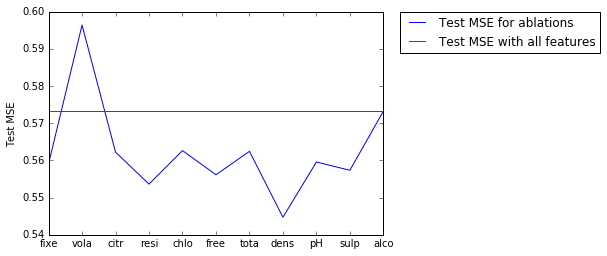

In [18]:
x =  range(len(list(wineFeatures)))
plt.xticks(x, [s[:4] for s in list(wineFeatures)])
plt.ylabel("Test MSE")
plt.plot(x, test_mse, label="Test MSE for ablations")
plt.plot(x, test_residual / len(y_test) * np.ones(len(x)), label="Test MSE with all features")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
print list(wineFeatures)
# print (test_mse - test_MSE)

Clearly the most additional information is given by **volatile acidity** feature and the least additional information is given by **density** feature

## 5. Classification using SVM

In [19]:
wineFeatures = pd.read_csv('winequality-white.csv', delimiter=';')
y = wineFeatures['quality'].values
del wineFeatures['quality']
X = wineFeatures.values
X = np.insert(X, 0, 1, axis=1)
print y[:20]
y = np.array([0 if x <= 5 else 1 for x in y])
print y[:20]

[6 6 6 6 6 6 6 6 6 6 5 5 5 7 5 7 6 8 6 5]
[1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0]


In [20]:
n_train = len(y) / 2 
X_train = X[:n_train, :]
y_train = y[:n_train]
X_test = X[n_train:, :]
y_test = y[n_train:]

In [21]:
clf = svm.SVC(C=1)
clf.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)
acc_train = accuracy_score(y_train, train_pred)
acc_test = accuracy_score(y_test, test_pred)
print "Training accuracy = ", acc_train
print "Testing accuracy = ", acc_test

Training accuracy =  0.912209064924
Testing accuracy =  0.690077582687


## 6. Classification using Logistic Regression

In [23]:
def inner(x,y):
    return sum([x[i]*y[i] for i in range(len(x))])

def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

# NEGATIVE Log-likelihood
def f(theta, X, y, lam):
    loglikelihood = 0
    for i in range(len(X)):
        logit = inner(X[i], theta)
        loglikelihood -= np.log(1 + np.exp(-logit))
        if not y[i]:
            loglikelihood -= logit
    for k in range(len(theta)):
        loglikelihood -= lam * theta[k]*theta[k]
#     print "ll =", loglikelihood
    return -loglikelihood

# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
    dl = [0.0]*len(theta)
    for i in range(len(X)):
        # Fill in code for the derivative
        logit = inner(X[i], theta)
        dl += (y[i] - sigmoid(logit)) * X[i]
    dl -= 2 * lam * theta
    # Negate the return value since we're doing gradient *ascent*
    return np.array([-x for x in dl])

In [24]:
X_train = X[:len(X)/2]
X_test = X[len(X)/2:]
y_train = y[:len(X)/2]
y_test = y[len(X)/2:]
# If we wanted to split with a validation set:
X_valid = X[len(X)/2:3*len(X)/4]
X_test = X[3*len(X)/4:]
y_valid = y[len(X)/2:3*len(X)/4]
y_test = y[3*len(X)/4:]

In [25]:
def ypred(y):
    return np.around(y)

In [26]:
lamSet = [0.01, 0.1, 1, 10, 100, 1000]
max_accuracy = -100
opt_lam = 1
for lam in lamSet:
    theta,l,info = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, args = (X_train, y_train, lam))
    print "Final log likelihood for lambda " , lam, " = ", -l
    accuracy = accuracy_score(y_valid, ypred(sigmoid(np.dot(X_valid, theta))))
    print "Accuracy for lambda " , lam, " = ", accuracy
    if(accuracy > max_accuracy):
        max_accuracy = accuracy
        opt_lam = lam
print "Optimal lambda = ", opt_lam

Final log likelihood for lambda  0.01  =  -1332.41038895
Accuracy for lambda  0.01  =  0.774509803922
Final log likelihood for lambda  0.1  =  -1340.7840153
Accuracy for lambda  0.1  =  0.77614379085
Final log likelihood for lambda  1  =  -1383.18368068
Accuracy for lambda  1  =  0.785130718954
Final log likelihood for lambda  10  =  -1458.42477232
Accuracy for lambda  10  =  0.755718954248
Final log likelihood for lambda  100  =  -1513.81835147
Accuracy for lambda  100  =  0.727124183007
Final log likelihood for lambda  1000  =  -1556.97818021
Accuracy for lambda  1000  =  0.71160130719
Optimal lambda =  1


In [27]:
theta,l,info = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, args = (X_train, y_train, opt_lam))
print "Final log likelihood =", -l
accuracy = accuracy_score(y_test, ypred(sigmoid(np.dot(X_test, theta))))
print "Accuracy = " , accuracy

Final log likelihood = -1383.18368068
Accuracy =  0.748571428571


In [28]:
# y_pred_vec = []
# for i in range(len(X_test)):
#     logit = inner(X_test[i], theta)
#     y_pred = sigmoid(logit)
#     if y_pred > 0.5:
#         y_pred = 1
#     else:
#         y_pred = 0
#     y_pred_vec.append(y_pred)
# acc2 = accuracy_score(y_test, y_pred_vec)
# print acc2